In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import cv2
import albumentations as albu
from albumentations.pytorch import ToTensor

In [3]:
import PIL
print('PIL',PIL.__version__)

PIL 6.2.1


In [4]:
import torch
import torch.nn as nn

from torchvision import transforms

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
train = pd.read_csv("./input/train.csv")
test = pd.read_csv("./input/test.csv")

y = train["label"].values
X = train.drop("label", axis=1).values
test = test.values
    
X = X.reshape(-1, 28, 28, 1).astype(np.float32)
test = test.reshape(-1, 28, 28, 1).astype(np.float32)

#X = X.reshape(-1, 28, 28)
#test = test.reshape(-1, 28, 28)

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.3)
    

In [7]:
train.shape

(42000, 785)

## Albumentation

In [8]:
class MNIST(torch.utils.data.Dataset):
    
    def __init__(self, images, labels, trans, flag=True):
        super().__init__()
        
        self.flag = flag
        self.trans = trans
        self.images = images
        self.labels = labels
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        
        if self.flag:
            image = self.images[idx]
            label = self.labels[idx]
            image = self.trans(image=image)['image']
            return image, label
        else:
            image = self.images[idx]
            image = self.trans(image=image)['image']
            return image

In [9]:
def train_augmentation():
    transform = [
        albu.Resize(32,32),
        albu.Normalize(mean=(0.485,), std=(0.229,)),
        ToTensor(),
    ]
    return albu.Compose(transform)

def test_augmentation():
    transform = [
        albu.Resize(32,32),
        albu.Normalize(mean=(0.485,), std=(0.229,)),
        ToTensor(),
    ]
    return albu.Compose(transform)

In [10]:
train_loader = torch.utils.data.DataLoader(MNIST(train_X, train_y, train_augmentation(), flag=True), batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(MNIST(val_X, val_y, train_augmentation(), flag=True), batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(MNIST(test, False, test_augmentation(), flag=False), batch_size=1, shuffle=False)

In [11]:
for image, label in train_loader:
    print(image.shape)
    break

torch.Size([64, 1, 32, 32])


# Models

In [12]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

In [13]:
class ResidualBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        
        return out

In [14]:
class ResNet(nn.Module):
    
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        
        self.in_channels = 16
        self.conv = conv3x3(1, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[0], 2)
        self.layer3 = self.make_layer(block, 64, layers[1], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        
        self.in_channels = out_channels
        
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        
        return out

In [15]:
net_args = {
    "block": ResidualBlock,
    "layers": [2, 2, 2, 2]
}

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
model = ResNet(**net_args).to(device)

In [18]:
num_epochs = 10
criterion = nn.CrossEntropyLoss()
learning_rate = 0.05
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
def learning(train_loader, val_loader):
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    
    for epoch in range(num_epochs):
        train_loss=0
        train_acc=0
        val_loss=0
        val_acc=0
        
        model.train()
        
        for i, (images, labels) in enumerate(train_loader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            
            loss = criterion(outputs, labels)
            
            train_loss += loss.item()
            train_acc += (outputs.max(1)[1] == labels).sum().item()
            
            loss.backward()
            
            optimizer.step()
            
        avg_train_loss = train_loss/ len(train_loader.dataset)
        avg_train_acc = train_acc / len(train_loader.dataset)
        
        model.eval()
        
        with torch.no_grad():
            
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_acc += (outputs.max(1)[1] == labels).sum().item()
            
            avg_val_loss = val_loss / len(val_loader.dataset)
            avg_val_acc = val_acc / len(val_loader.dataset)
            
        print('Epoch[{}/{}]'.format(epoch+1,  num_epochs))
        
        train_loss_list.append(avg_train_loss)
        train_acc_list.append(avg_train_acc)
        val_loss_list.append(avg_val_loss)
        val_acc_list.append(avg_val_acc)
    
    loss_list = [train_loss_list, val_loss_list]
    acc_list = [train_acc_list, val_acc_list]
    return loss_list, acc_list

In [20]:
loss_list, acc_list = learning(train_loader, val_loader)

Epoch[1/10]
Epoch[2/10]
Epoch[3/10]
Epoch[4/10]
Epoch[5/10]
Epoch[6/10]
Epoch[7/10]
Epoch[8/10]
Epoch[9/10]
Epoch[10/10]


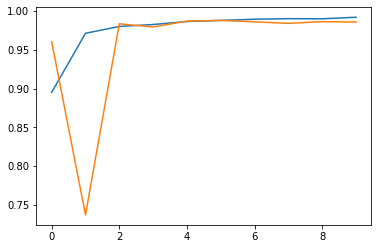

In [21]:
plt.plot(acc_list[0])
plt.plot(acc_list[1])
plt.show()

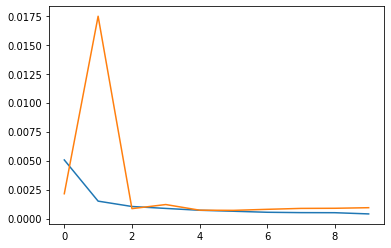

In [22]:
plt.plot(loss_list[0])
plt.plot(loss_list[1])
plt.show()

# save

In [25]:
'''
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
'''

'\nprint("Model\'s state_dict:")\nfor param_tensor in model.state_dict():\n    print(param_tensor, "\t", model.state_dict()[param_tensor].size())\n'

In [26]:
'''
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])
'''

'\nprint("Optimizer\'s state_dict:")\nfor var_name in optimizer.state_dict():\n    print(var_name, "\t", optimizer.state_dict()[var_name])\n'

In [29]:
#torch.save(model.state_dict(), "model.pth")

# load

In [20]:
model.load_state_dict(torch.load("model.pth"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

# suiron

In [21]:
pred_list = []
with torch.no_grad():
    model.eval()
    c = 0
    for images in test_loader:
        images = images.to(device)
        output = model.forward(images)
        _, pred = torch.max(output.data, 1) 
        pred_list.append(pred.item())

In [22]:
pred_list = np.array(pred_list)
ID_lists= np.arange(1, pred_list.shape[0]+1) 
 
submissions=pd.DataFrame({"ImageId": ID_lists,
                         "Label": pred_list})
submissions.to_csv("submissions1.csv", index=False, header=True)

In [23]:
submissions.Label.value_counts()

1    3218
8    2869
0    2842
7    2827
2    2769
6    2761
4    2754
9    2720
3    2716
5    2524
Name: Label, dtype: int64

In [24]:
submissions

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
